In [11]:
%%HTML
<h1>Introdução

Navegando pelo subreddit Data Is Beautiful (https://www.reddit.com/r/dataisbeautiful/) me deparei com uma postagem que exibia um mapa das regiões dos jogos do Pokémon e que tipo de Pokémon era possível encontrar em cada área. Me lembrei de quando jogava e sempre me questionava se existia um tipo de Pokémon mais fortes do que os outros, quais eram as peculiaridades de cada tipo, entre outros. Utilizando a base de dados disponível em https://pokemondb.net/, tentarei achar uma resposta para essas perguntas.

<h1>Desenvolvimento

No link https://pokemondb.net/pokedex/all encontra-se as estatísticas dos Pokémons presentes em todos os jogos da série - ou gerações. Existem 18 tipos de Pokémons: Normal, Fogo, Água, Elétrico, Planta, Gelo, Lutador, Venenoso, Terra, Voador, Psíquico, Inseto, Pedra, Fantasma, Dragão, Noturno, Metálico e Fada. Para avaliar o poder de um Pokémon é utilizado o valor Total, que corresponde à soma de outros 6 valores característicos de cada Pokémon: Ataque, Defesa, Ataque Especial, Defesa Especial, Pontos de Vida (HP) e Velocidade. Ataque e Defesa especial é uma modalidade de combate sem contato físico entre os Pokémons.
Estrutura dos dados:

| Número | Nome | Tipo | Total | HP | Ataque | Defesa | Ataque Especial | Defesa Especial | Velocidade | 


Começando a análise, selecionei a tabela inteira com os dados e copiei pro OpenOffice Calc para ver o que acontecia. Está bem estruturado mas vários Pokémons possuem dois tipos, precisarei duplicar as características desses e atribuir para os dois tipos. Salvando em CSV fica um pouco bagunçado pois tem vários '\n' no meio das células, vou importar desse jeito e consertar no Python mesmo.
Primeiramente vou abrir o arquivo.

In [30]:
%matplotlib inline
file = open('teste2.csv', 'r')

Os dados em csv estão um pouco desorganizados, possuem caracteres de espaço e nova linha. Esses caracteres geram quebras de linhas e colunas onde não deveria e precisam ser removidos. Além disso preciso duplicar os Pokémons com dois tipos diferentes.
Começo iniciando algumas variáveis, lendo o arquivo linha por linha e tratando dos problemas.

In [31]:
data = []
count = 0
LastRowCols = 0

# Varre linha por linha do arquivo
for line in file.readlines():
    # Transfere a linha atual do arquivo para a última linha da variável data, removendo o caracter '\n' e dividindo as colunas
    data.append(line.replace('\n','').split(';'))

    # Existem três problemas com os dados:
    # -> Nomes compostos de Pokémons separados por espaço são divididos em duas colunas
    # -> Nomes com subnomes são separados por '\n' e confundidos por uma nova linha
    # -> Pokémons possuem um ou dois tipos, no segundo caso os tipos são separados por '\n' e confundidos por uma nova linha
    # Arrumar na mão iria demorar e, para outra pessoa reutilizar meu código, passaria pelo mesmo trabalho. Então vou corrigir
    # no código mesmo. Analiso a quantidade de coluna de uma linha, cada um dos problemas citados acima acarreta em um número 
    # menor de colunas, o resto da informação ficou na próxima linha.
    
    
    #-Caso a linha atual seja o resto de informação da linha anterior--#
                                                                       #
    if (LastRowCols == 3):                                             #
        data[count-1][3:] = data[count][1:8]                           #
        data[count][2:10] = data[count][0:8]                           #
        data[count][0:2] = data[count-1][0:2]                          #
        LastRowCols = 0                                                #
                                                                       #
    if (LastRowCols == 4):                                             #
        data[count-1][1] = data[count-1][1] + ' ' + data[count-1][2]   #
        data[count-1][2] = data[count-1][3]                            #
        data[count-1][3:] = data[count][1:9]                           #
        data[count][2:10] = data[count][0:9]                           #
        data[count][0:2] = data[count-1][0:2]                          #
        LastRowCols = 0                                                #
                                                                       #
    if (LastRowCols == 2):                                             #
        data[count-1][1] = data[count-1][1] + ' ' + data[count][0]     #
        data[count-1][2:] = data[count][1:]                            #
        if (len(data[count-1]) == 3):                                  #
            LastRowCols = 3                                            #
        else:                                                          #
            LastRowCols = 0                                            #
        del data[count]                                                #
        count -= 1                                                     #
                                                                       #
    if (LastRowCols == 11):                                            #
        data[count-1][1] = data[count-1][1] + ' ' + data[count-1][2]   #
        data[count-1][2:-2] = data[count-1][3:-1]                      #
        LastRowCols = 0
    ####################################################################
    
    # Se a linha atual tem três colunas: o Pokémon possui dois tipos
    if (len(data[count]) == 3):
        LastRowCols = 3
    # onze colunas e última não nula: o Pokémon possui nome composto
    elif ((len(data[count]) == 11) and (data[count][-1] != '')):
        LastRowCols = 11
    # quatro colunas: o Pokémon possui nome composto e dois tipos
    elif (len(data[count]) == 4):
        LastRowCols = 4
    # duas colunas: o Pokémon possui nome e subnome
    elif (len(data[count]) == 2):
        LastRowCols = 2   

    # Essas foram as únicas ocorrências de erros, com a adição de novos Pokémons ou alterações em futuras gerações,
    # o tratamento desses erros deve ser revisto.
    
    
    count+=1

#print(data)

Se exibirmos a variável dos dados ainda percebe-se alguns caracteres de new line, algumas aspas perdidas no meio de algumas colunas e algumas linhas possuem uma coluna adicional vazia. Removerei todos esses objetos indesejados.

Vou transformar em array as colunas com valores inteiros para facilitar algumas manipulações.

In [32]:
import copy
import numpy as np

Names = []
Types = []
for i in range(0,len(data)):
    for j in range(0,len(data[i])):
        data[i][j] = data[i][j].replace('\xa0','')
        data[i][j] = data[i][j].replace('"','')
        if ((j!=1) and (j!=2) and (j!=10)):
            data[i][j] = int(data[i][j])
    if (len(data[i])==11):
        del data[i][10]
    Names.append(data[i][1])
    Types.append(data[i][2])

data2 = copy.deepcopy(data)
for i in range(0,len(data2)):
    del data2[i][1:3]
NPdata = np.asarray(data2)

Vou importar a biblioteca matplotlib e verificar a distribuição dos pontos de ataque e defesa para todos os Pokémons.

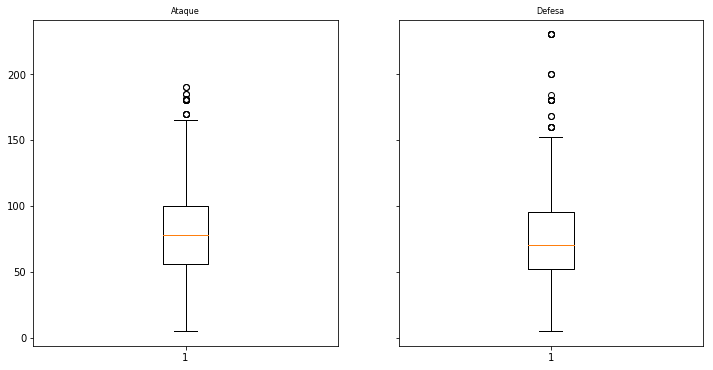

In [33]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
axes[0].boxplot(NPdata[:,3])
axes[0].set_title('Ataque', fontsize=8)

axes[1].boxplot(NPdata[:,4])
axes[1].set_title('Defesa', fontsize=8)
plt.show()

Vou ver as os valores de ataque e defesa especial

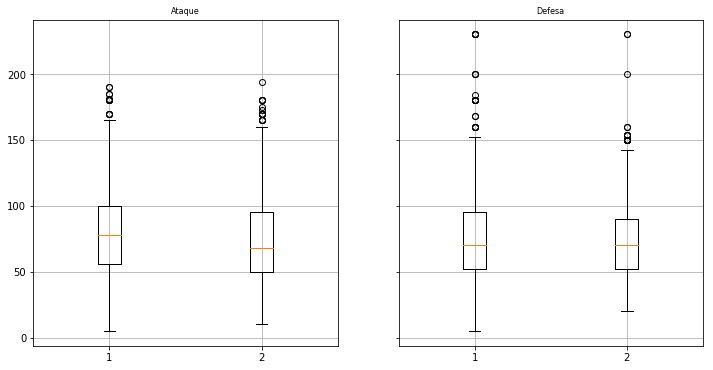

In [34]:
Atcks = np.zeros([len(NPdata), 2])
Atcks[:,0] = NPdata[:,3]
Atcks[:,1] = NPdata[:,5]
Defs = np.zeros([len(NPdata), 2])
Defs[:,0] = NPdata[:,4]
Defs[:,1] = NPdata[:,6]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
axes[0].boxplot(Atcks)
axes[0].set_title('Ataque', fontsize=8)
axes[0].grid(True)

axes[1].boxplot(Defs)
axes[1].set_title('Defesa', fontsize=8)
axes[1].grid(True)

plt.show()


São bem parecidos, o que é esperado. Ataque especial não é um golpe necessariamente mais forte, mas um golpe sem contato físico com o oponente. Defesa especial é a resistência de um ataque especial.

Quero ver se Pokémons normalmente tem os pontos de ataque e defesa parecidos ou são balanceados.

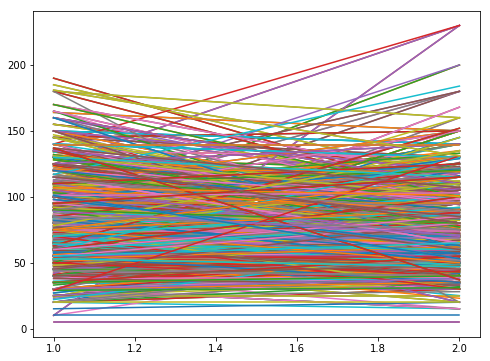

In [35]:
y = [1,2]
fig = plt.figure(figsize=(8, 6))
for i in range(0,len(Atcks)):
    plt.plot(y,[Atcks[i,0],Defs[i,0]])

Não da pra ver muita coisa, vou tentar filtrar para mostrar só os mais fortes e mais fracos. Também deixar o gráfico mais agradável.

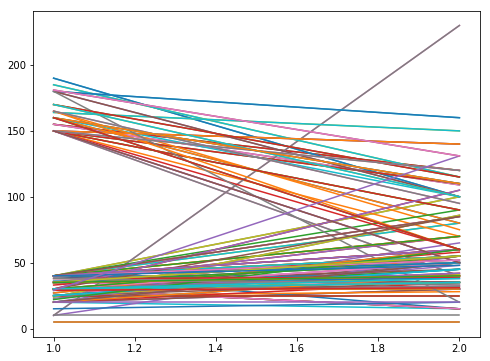

In [36]:
y = [1,2]
fig,ax = plt.subplots(figsize=(8, 6))
for i in range(0,len(Atcks)):
    if ((Atcks[i,0] >= 150) or (Atcks[i,0] <= 40)):
        plt.plot(y,[Atcks[i,0],Defs[i,0]])

Melhorou, me parece que vários Pokémons com ataque baixo também possuem uma defesa baixa, devem ser Pokémons não evoluídos. Por outro lado os Pokémons com ataque alto tem pontos de defesas distribuídos. Mas alguns poucos parecem estar no topo dos dois.

Quero ver se esses Pokémons com ataque baixo e defesa mais alta são de um tipo específico.

<Container object of 18 artists>

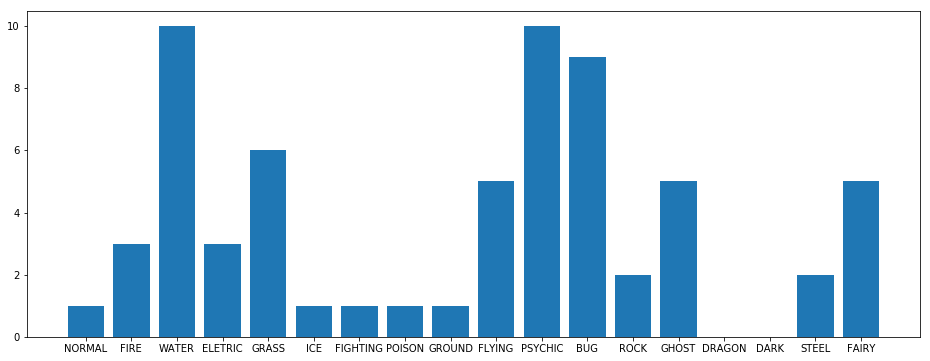

In [37]:
# Vou definir essa função aqui pq parece que será útil mais tarde também
def TypePoint(Type, Points, Value):
    if (Type=='NORMAL'):
        Points[0] += Value
    elif (Type=='FIRE'):
        Points[1] += Value
    elif (Type=='WATER'):
        Points[2] += Value
    elif (Type=='ELECTRIC'):
        Points[3] += Value
    elif (Type=='GRASS'):
        Points[4] += Value
    elif (Type=='ICE'):
        Points[5] += Value
    elif (Type=='FIGHTING'):
        Points[6] += Value
    elif (Type=='POISON'):
        Points[7] += Value
    elif (Type=='GROUND'):
        Points[8] += Value
    elif (Type=='FLYING'):
        Points[9] += Value
    elif (Type=='PSYCHIC'):
        Points[10] += Value
    elif (Type=='BUG'):
        Points[11] += Value
    elif (Type=='ROCK'):
        Points[12] += Value
    elif (Type=='GHOST'):
        Points[13] += Value
    elif (Type=='DRAGON'):
        Points[14] += Value
    elif (Type=='DARK'):
        Points[15] += Value
    elif (Type=='STEEL'):
        Points[16] += Value
    elif (Type=='FAIRY'):
        Points[17] += Value    
    return Points;
   

dicionario = {0:'NORMAL',1:'FIRE',2:'WATER',3:'ELETRIC',4:'GRASS',5:'ICE',
              6:'FIGHTING',7:'POISON',8:'GROUND',9:'FLYING',10:'PSYCHIC',
              11:'BUG',12:'ROCK',13:'GHOST',14:'DRAGON',15:'DARK',
              16:'STEEL',17:'FAIRY'}

PontuacaoPorTipo = np.zeros(18)
for i in range(0,len(Atcks)):
    if ((Atcks[i,0] <= 40) and (Defs[i,0] >=50)):
        PontuacaoPorTipo = TypePoint(data[i][2], PontuacaoPorTipo, 1)

fig, ax = plt.subplots(figsize=(16, 6))
labels = []
for i in range(0,len(dicionario)):
    labels.append(dicionario.get(i))
TypeNmbrs = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]
plt.bar(TypeNmbrs, PontuacaoPorTipo, tick_label=labels)

            

Eu espereva por Pokémons que são um casulo, do tipo inseto, mas vejo que tem vários Psíquicos e de Água com baixo ataque e defesa elevada.

Partindo para minha dúvida inicial, tentarei verificar se um tipo de Pokémon se destaca com maior número de Pokémons na lista dos mais fortes.

<Container object of 18 artists>

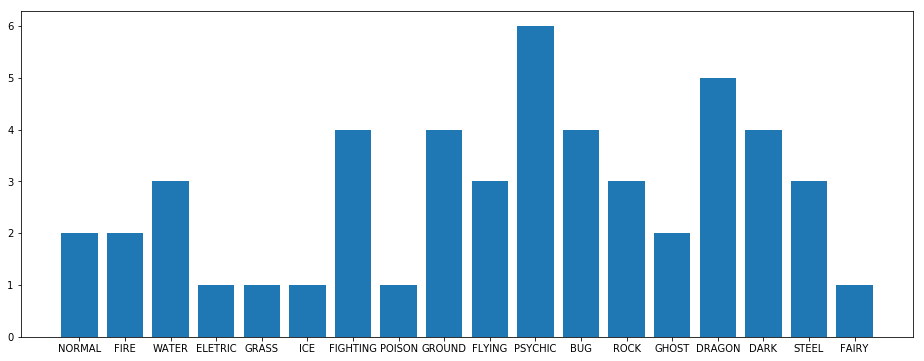

In [38]:
PontuacaoPorTipo = np.zeros(18)
for i in range(0,len(Atcks)):
    if (Atcks[i,0] >= 150):
        PontuacaoPorTipo = TypePoint(data[i][2], PontuacaoPorTipo, 1)

fig, ax = plt.subplots(figsize=(16, 6))
plt.bar(TypeNmbrs, PontuacaoPorTipo, tick_label=labels)


Vários Pokémons Psíquicos com ataque alto. Lembrando que estou vendo apenas a modalidade de combate com contato físico. O comportamento deve mudar se olharmos para a defesa.

<Container object of 18 artists>

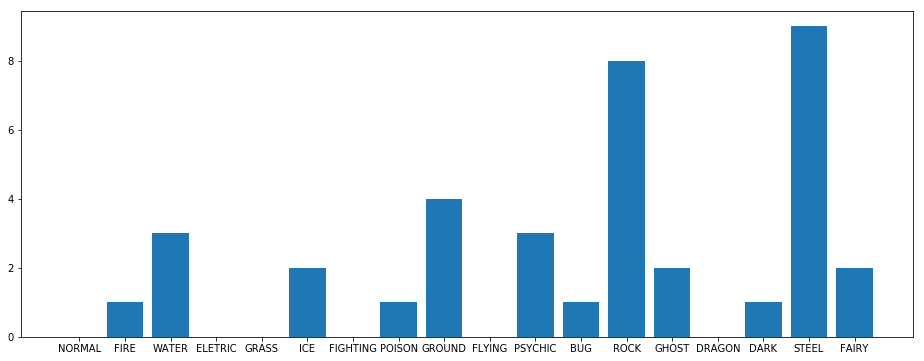

In [39]:
PontuacaoPorTipo = np.zeros(18)
for i in range(0,len(Defs)):
    if (Defs[i,0] >= 150):
        PontuacaoPorTipo = TypePoint(data[i][2], PontuacaoPorTipo, 1)
fig, ax = plt.subplots(figsize=(16, 6))
plt.bar(TypeNmbrs, PontuacaoPorTipo, tick_label=labels)

Olhando esses dois gráficos já dá para perceber que não vale a pena investir em certos tipos de Pokemons. Não existem Pokémons do tipo Elétrico e Planta, por exemplo, entre aqueles com maior defesa e apenas um Pokémon entre aqueles com maior ataque. Os tipos com mais Pokémons na lista dos melhores estão Pedra, Metálico, Psíquico, Terra e Água. Mas será que na média esse comportamento é o mesmo? Qual é a quantidade de Pokémon de cada tipo e a média de ataque/defesa desses?

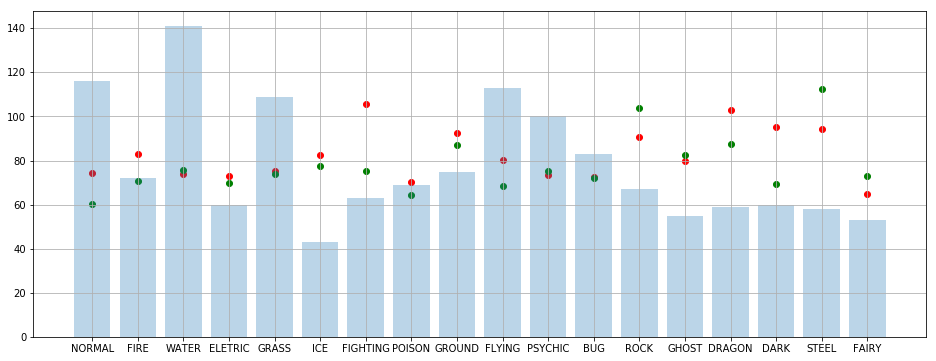

In [52]:
PontoAtaque = np.zeros(18)
PontoDefesa = np.zeros(18)
QtdPokemon = np.zeros(18)
for i in range(0,len(Atcks)):
    PontoAtaque = TypePoint(data[i][2], PontoAtaque, Atcks[i,0])
    PontoDefesa = TypePoint(data[i][2], PontoDefesa, Defs[i,0])
    QtdPokemon = TypePoint(data[i][2], QtdPokemon, 1)
# Normaliza os pontos de ataque e defesa
PontoAtaque = PontoAtaque/QtdPokemon
PontoDefesa = PontoDefesa/QtdPokemon

fig, ax = plt.subplots(figsize=(16, 6))
ax.grid(True)
plt.bar(TypeNmbrs, QtdPokemon, tick_label=labels, alpha=0.3)
plt.scatter(TypeNmbrs, PontoAtaque, color='r')
plt.scatter(TypeNmbrs, PontoDefesa, color='g')
plt.show()

As representam quantidade de Pokémons, bolas vermelhas o ataque médio e bola verde a defesa média.

Podemos ver que, na média, Pokémons Lutadores têm ataques mais fortes, seguidos dos Dragões. Na defesa os melhores são Metálicos e Pedra, como esperado. Eu poderia colocar o valor normalizado dos pontos de vida também, pode ser que algum outro tipo tenha destaque.

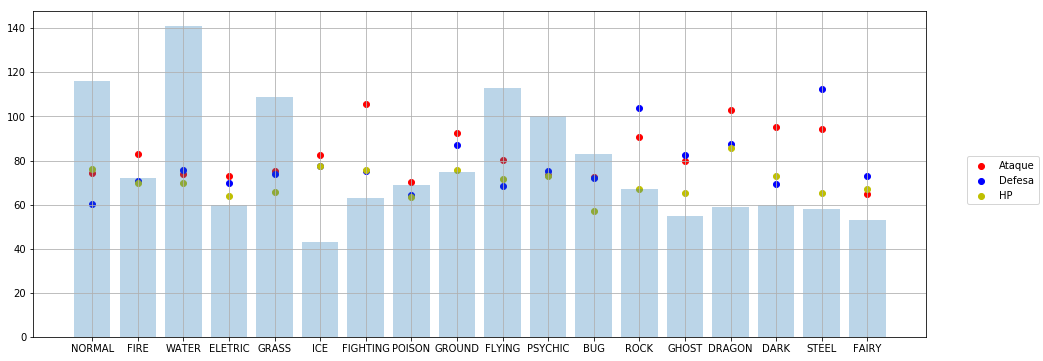

In [86]:
HP = np.zeros([len(NPdata), 2])
HP[:,0] = NPdata[:,2]
PontoHP = np.zeros(18)
for i in range(0,len(HP)):
    PontoHP = TypePoint(data[i][2], PontoHP, HP[i,0])
PontoHP = PontoHP/QtdPokemon
fig, ax = plt.subplots(figsize=(16, 6))
ax.grid(True)
plt.bar(TypeNmbrs, QtdPokemon, tick_label=labels, alpha=0.3)
Handle_Atk = plt.scatter(TypeNmbrs, PontoAtaque, color='r')
Handle_Def = plt.scatter(TypeNmbrs, PontoDefesa, color='b')
Handle_HP = plt.scatter(TypeNmbrs, PontoHP, color='y')
plt.figlegend( (Handle_Atk, Handle_Def, Handle_HP) , ('Ataque','Defesa','HP') , 'center right' )
plt.show()

Ok, mas esse é o comportamento normalizado. Vou ver um boxplot de cada tipo para ver se traz mais alguma informação.

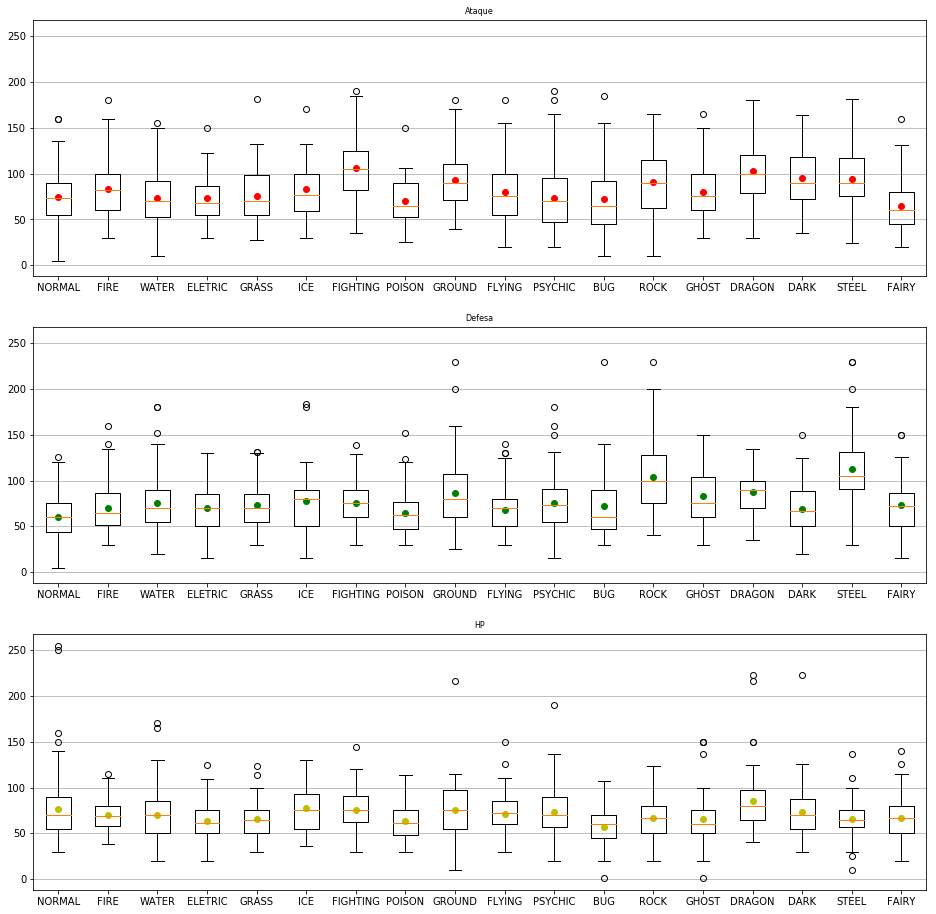

In [78]:
TypeAtcks = [[] for i in range(0,18)]
TypeDefs = [[] for i in range(0,18)]
TypeHP = [[] for i in range(0,18)]
for i in range(0,len(data)):
    Aux = np.zeros(18)
    Aux = TypePoint(data[i][2], Aux, Atcks[i,0])
    TypeAtcks[np.where(Aux!=0)[0][0]].append(sum(Aux))
    Aux = np.zeros(18)
    Aux = TypePoint(data[i][2], Aux, Defs[i,0]) 
    TypeDefs[np.where(Aux!=0)[0][0]].append(sum(Aux))
    Aux = np.zeros(18)
    Aux = TypePoint(data[i][2], Aux, HP[i,0])
    TypeHP[np.where(Aux!=0)[0][0]].append(sum(Aux))
    
TypeNmbrs1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 16), sharey=True)
axes[0].boxplot(TypeAtcks)
axes[0].scatter(TypeNmbrs1, PontoAtaque, color='r')
axes[0].set_title('Ataque', fontsize=8)
axes[0].grid(b=True,axis='y')
axes[0].set_xticklabels(labels)

axes[1].boxplot(TypeDefs)
axes[1].scatter(TypeNmbrs1, PontoDefesa, color='g')
axes[1].set_title('Defesa', fontsize=8)
axes[1].grid(b=True,axis='y')
axes[1].set_xticklabels(labels)

axes[2].boxplot(TypeHP)
axes[2].scatter(TypeNmbrs1, PontoHP, color='y')
axes[2].set_title('HP', fontsize=8)
axes[2].grid(b=True,axis='y')
axes[2].set_xticklabels(labels)
plt.show()

No geral a média e a mediana estão bem próximas. Esses boxplots confirmam o que visualizações anteriores já indicavam, as estatísticas dos Pokémons são balanceadas - levando em consideração que, nesses dados, também estão presentes Pokémons lendários. Agora gostaria de verificar os ataques especiais, aqueles que não precisam de contato físico.

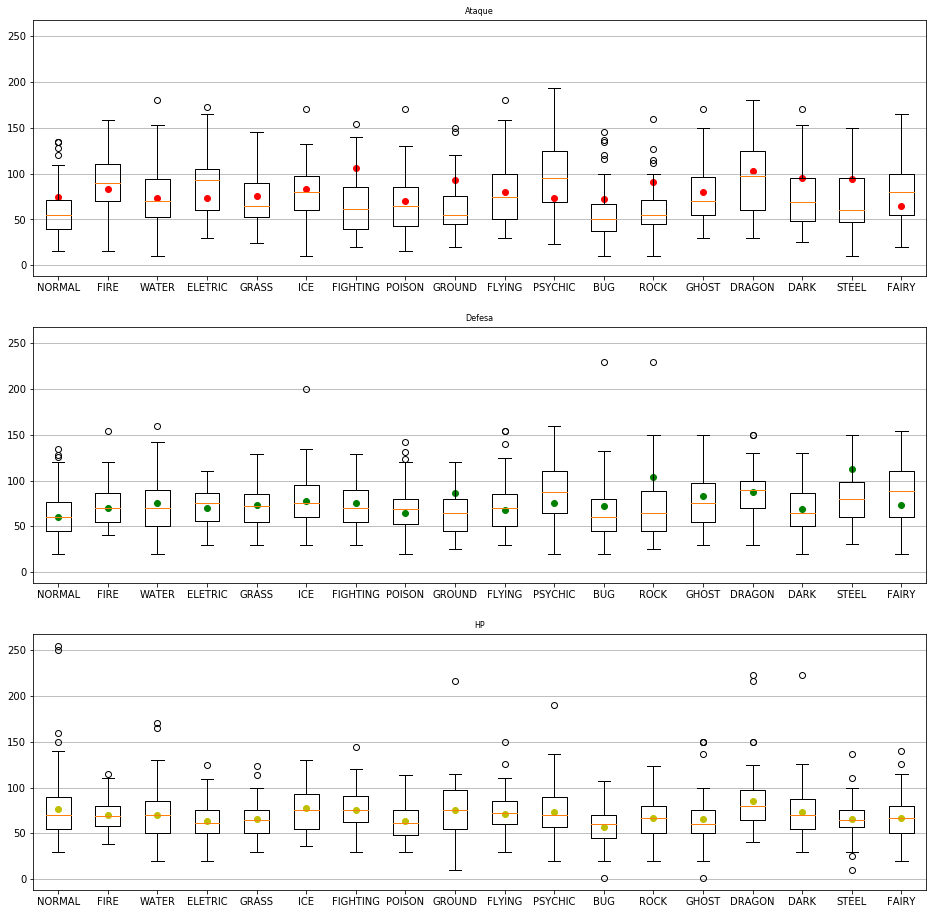

In [87]:
TypeAtcks = [[] for i in range(0,18)]
TypeDefs = [[] for i in range(0,18)]
TypeHP = [[] for i in range(0,18)]
for i in range(0,len(data)):
    Aux = np.zeros(18)
    Aux = TypePoint(data[i][2], Aux, Atcks[i,1])
    TypeAtcks[np.where(Aux!=0)[0][0]].append(sum(Aux))
    Aux = np.zeros(18)
    Aux = TypePoint(data[i][2], Aux, Defs[i,1]) 
    TypeDefs[np.where(Aux!=0)[0][0]].append(sum(Aux))
    Aux = np.zeros(18)
    Aux = TypePoint(data[i][2], Aux, HP[i,0])
    TypeHP[np.where(Aux!=0)[0][0]].append(sum(Aux))
    
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 16), sharey=True)
axes[0].boxplot(TypeAtcks)
axes[0].scatter(TypeNmbrs1, PontoAtaque, color='r')
axes[0].set_title('Ataque', fontsize=8)
axes[0].grid(b=True,axis='y')
axes[0].set_xticklabels(labels)

axes[1].boxplot(TypeDefs)
axes[1].scatter(TypeNmbrs1, PontoDefesa, color='g')
axes[1].set_title('Defesa', fontsize=8)
axes[1].grid(b=True,axis='y')
axes[1].set_xticklabels(labels)

axes[2].boxplot(TypeHP)
axes[2].scatter(TypeNmbrs1, PontoHP, color='y')
axes[2].set_title('HP', fontsize=8)
axes[2].grid(b=True,axis='y')
axes[2].set_xticklabels(labels)
plt.show()

Tipo como Metálico, Lutador e Pedra não se destacam mais nessas modalidades de duelo. Dando espaço para tipos como Psíquico, Voador e Elétrico. O único que se destacou em ambas modalidades foi o tipo Dragão. Utilizarei a contagem soma das estatísticas dos Pokémons para decidir se realmente existe um tipo mais forte. 

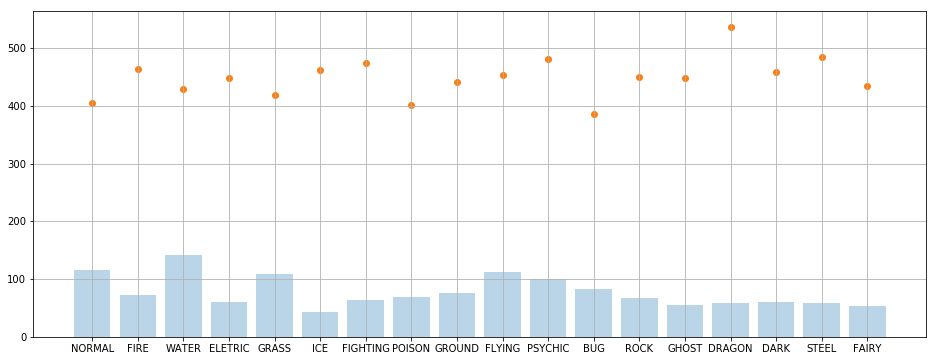

In [93]:
Total = np.zeros([len(NPdata), 2])
Total[:,0] = NPdata[:,1]
PontoTotal = np.zeros(18)
for i in range(0,len(HP)):
    PontoTotal = TypePoint(data[i][2], PontoTotal, Total[i,0])
PontoTotal = PontoTotal/QtdPokemon
fig, ax = plt.subplots(figsize=(16, 6))
ax.grid(True)
plt.bar(TypeNmbrs, QtdPokemon, tick_label=labels, alpha=0.3)
Handle_Total = plt.scatter(TypeNmbrs, PontoTotal)
plt.show()

Analisando os resultados até aqui penso que, para gerar uma visualização que responda as minhas perguntas, devo exibir o valor médio dos ataques, defesas e HP de cada tipo. Exibir a quantidade de melhores Pokémons de cada tipo pode passar a ideia errada. Também devo apresentar os dois modos de combate (ou a média deles), já que cada tipo de Pokémon se destaca em um modo.

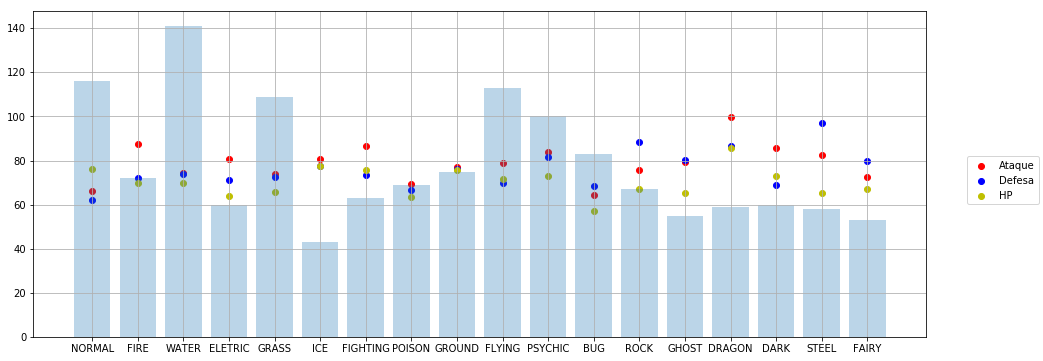

In [97]:
Ponto2Ataques = np.zeros(18)
Ponto2Defesas = np.zeros(18)
for i in range(0,len(Atcks)):
    Ponto2Ataques = TypePoint(data[i][2], Ponto2Ataques, (Atcks[i,0]+Atcks[i,1])/2)
    Ponto2Defesas = TypePoint(data[i][2], Ponto2Defesas, (Defs[i,0]+Defs[i,1])/2) 
Ponto2Ataques = Ponto2Ataques/QtdPokemon
Ponto2Defesas = Ponto2Defesas/QtdPokemon
fig, ax = plt.subplots(figsize=(16, 6))
ax.grid(True)
plt.bar(TypeNmbrs, QtdPokemon, tick_label=labels, alpha=0.3)
Handle_Atk = plt.scatter(TypeNmbrs, Ponto2Ataques, color='r')
Handle_Def = plt.scatter(TypeNmbrs, Ponto2Defesas, color='b')
Handle_HP = plt.scatter(TypeNmbrs, PontoHP, color='y')
plt.figlegend( (Handle_Atk, Handle_Def, Handle_HP) , ('Ataque','Defesa','HP') , 'center right' )
plt.show()

Realmente juntar as duas modalidades de combate é importante. Nesse gráfico, diferentemente dos anteriores, percebe-se que Pokémons Lutadores e de Fogo possuem mais ou menos o mesmo poder de ataque. Mostrar a quantidade de Pokémons por tipo também é muito interessante, alguém (como eu) que jogou os jogos poderiam imaginar um distribuição bem diferente.

Tentando melhorar o gráfico:

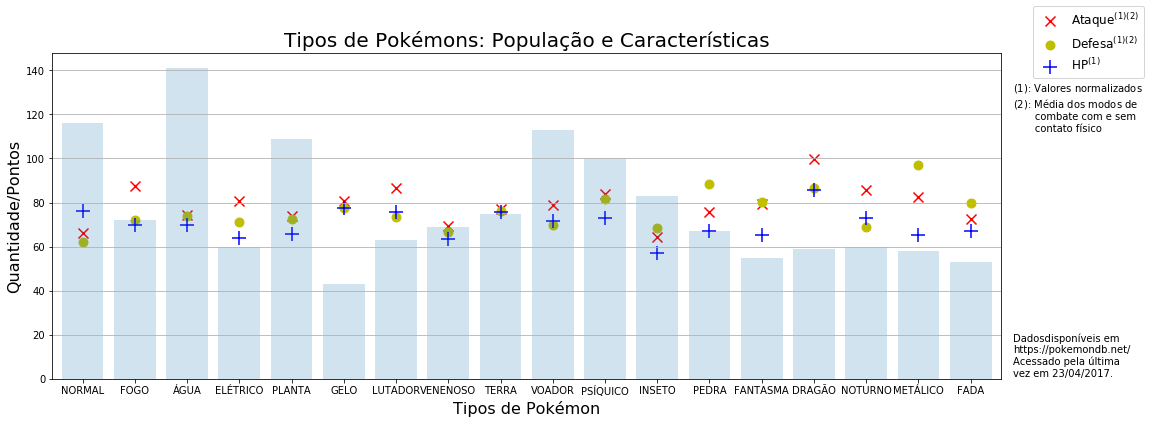

In [217]:
fig, ax = plt.subplots(figsize=(17, 6))
dicionario2 = {0:'NORMAL',1:'FOGO',2:'ÁGUA',3:'ELÉTRICO',4:'PLANTA',5:'GELO',
              6:'LUTADOR',7:'VENENOSO',8:'TERRA',9:'VOADOR',10:'PSÍQUICO',
              11:'INSETO',12:'PEDRA',13:'FANTASMA',14:'DRAGÃO',15:'NOTURNO',
              16:'METÁLICO',17:'FADA'}
labels2 = []
for i in range(0,len(dicionario2)):
    labels2.append(dicionario2.get(i))
ax.grid(b=True, axis='y')
plt.bar(TypeNmbrs, QtdPokemon, tick_label=labels2, alpha=0.2)
ax.set_title('Tipos de Pokémons: População e Características', fontsize=20)
ax.set_xmargin(0.01)
Handle_Atk = plt.scatter(TypeNmbrs, Ponto2Ataques, color='r', marker='x', s = 100)
Handle_Def = plt.scatter(TypeNmbrs, Ponto2Defesas, color='y', marker='o', s = 80)
Handle_HP = plt.scatter(TypeNmbrs, PontoHP, color='b', marker='+', s = 190)
plt.figlegend( (Handle_Atk, Handle_Def, Handle_HP) , 
              ('Ataque$^{(1)(2)}$','Defesa$^{(1)(2)}$','HP$^{(1)}$') , 'upper right' , fontsize=12)
plt.figtext(0.91,0.7,'$(1)$: Valores normalizados\n$(2)$: Média dos modos de\n       combate com e sem\n       contato físico', fontsize=10)
plt.figtext(0.91,0.13,'Dadosdisponíveis em \nhttps://pokemondb.net/\nAcessado pela última\nvez em 23/04/2017.')
plt.xlabel('Tipos de Pokémon', fontsize=16)
plt.ylabel('Quantidade/Pontos', fontsize=16)
plt.show()

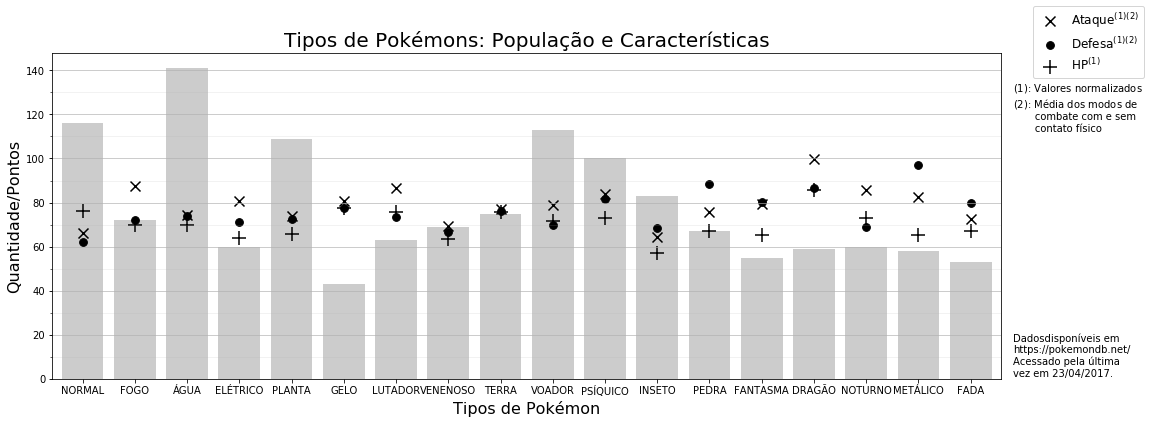

In [248]:
fig, ax = plt.subplots(figsize=(17, 6))
dicionario2 = {0:'NORMAL',1:'FOGO',2:'ÁGUA',3:'ELÉTRICO',4:'PLANTA',5:'GELO',
              6:'LUTADOR',7:'VENENOSO',8:'TERRA',9:'VOADOR',10:'PSÍQUICO',
              11:'INSETO',12:'PEDRA',13:'FANTASMA',14:'DRAGÃO',15:'NOTURNO',
              16:'METÁLICO',17:'FADA'}
labels2 = []
for i in range(0,len(dicionario2)):
    labels2.append(dicionario2.get(i))
minor_ticks = np.arange(0, 141, 10)
ax.set_yticks(minor_ticks, minor=True)  
ax.grid(b=True,axis='y', which='minor', alpha=0.2)
ax.grid(b=True,axis='y', which='major', alpha=0.7)

plt.bar(TypeNmbrs, QtdPokemon, tick_label=labels2, alpha=0.2, color='black')
ax.set_title('Tipos de Pokémons: População e Características', fontsize=20)
ax.set_xmargin(0.01)
Handle_Atk = plt.scatter(TypeNmbrs, Ponto2Ataques, color='black', marker='x', s = 100)
Handle_Def = plt.scatter(TypeNmbrs, Ponto2Defesas, color='black', marker='o', s = 60)
Handle_HP = plt.scatter(TypeNmbrs, PontoHP, color='black', marker='+', s = 190)
plt.figlegend( (Handle_Atk, Handle_Def, Handle_HP) , 
              ('Ataque$^{(1)(2)}$','Defesa$^{(1)(2)}$','HP$^{(1)}$') , 'upper right' , fontsize=12)
plt.figtext(0.91,0.7,'$(1)$: Valores normalizados\n$(2)$: Média dos modos de\n       combate com e sem\n       contato físico', fontsize=10)
plt.figtext(0.91,0.13,'Dadosdisponíveis em \nhttps://pokemondb.net/\nAcessado pela última\nvez em 23/04/2017.')
plt.xlabel('Tipos de Pokémon', fontsize=16)
plt.ylabel('Quantidade/Pontos', fontsize=16)
plt.show()

In [14]:
%%HTML
<h1> Conclusão</h1>

Analisando o gráfico abaixo, é possível concluir que não compensa investir em certos tipos de Pokémons - como Inseto, Venenoso e Normal. Por outro lado, existem alguns tipos com Pokémons mais fortes - como Dragão, Metálico e Psíquico, possuindo ambos pontos acima da faixa de 80. Portanto considero minha pergunta respondida. Conhecendo um pouco o jogo e olhando para esses dados, já é possível pensar em algumas estratégias. Uma delas seria investir em Pokémons Lutadores e Psíquicos e, mais tarde, nos Metálicos e Dragões (já que não aparecem no início do jogo).

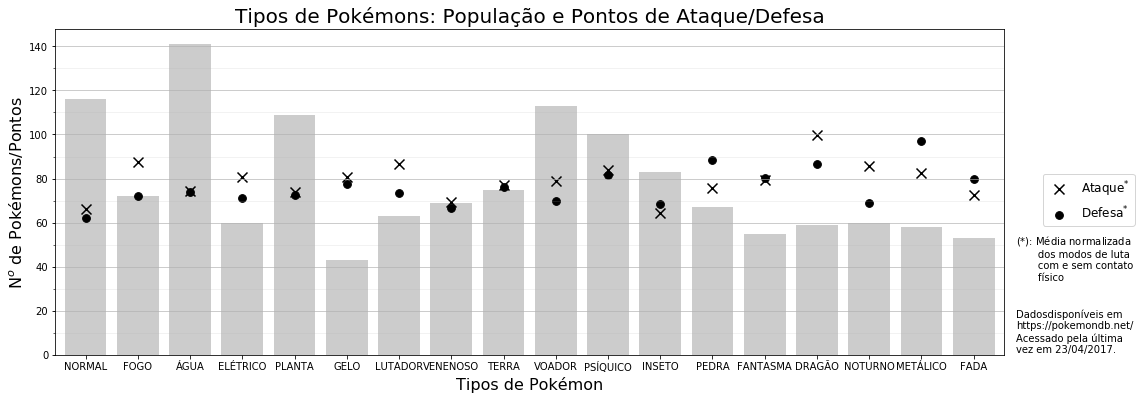

In [266]:
fig, ax = plt.subplots(figsize=(17, 6))
dicionario2 = {0:'NORMAL',1:'FOGO',2:'ÁGUA',3:'ELÉTRICO',4:'PLANTA',5:'GELO',
              6:'LUTADOR',7:'VENENOSO',8:'TERRA',9:'VOADOR',10:'PSÍQUICO',
              11:'INSETO',12:'PEDRA',13:'FANTASMA',14:'DRAGÃO',15:'NOTURNO',
              16:'METÁLICO',17:'FADA'}
labels2 = []
for i in range(0,len(dicionario2)):
    labels2.append(dicionario2.get(i))
minor_ticks = np.arange(0, 141, 10)
ax.set_yticks(minor_ticks, minor=True)  
ax.grid(b=True,axis='y', which='minor', alpha=0.2)
ax.grid(b=True,axis='y', which='major', alpha=0.7)

plt.bar(TypeNmbrs, QtdPokemon, tick_label=labels2, alpha=0.2, color='black')
ax.set_title('Tipos de Pokémons: População e Pontos de Ataque/Defesa', fontsize=20)
ax.set_xmargin(0.01)
Handle_Atk = plt.scatter(TypeNmbrs, Ponto2Ataques, color='black', marker='x', s = 100)
Handle_Def = plt.scatter(TypeNmbrs, Ponto2Defesas, color='black', marker='o', s = 60)
#Handle_HP = plt.scatter(TypeNmbrs, PontoHP, color='black', marker='+', s = 190)
plt.figlegend( (Handle_Atk, Handle_Def) , 
              ('Ataque$^{*}$','Defesa$^{*}$') , 'center right' , fontsize=12)
plt.figtext(0.91,0.3,'$(*)$: Média normalizada\n       dos modos de luta\n       com e sem contato\n       físico', fontsize=10)
plt.figtext(0.91,0.13,'Dadosdisponíveis em \nhttps://pokemondb.net/\nAcessado pela última\nvez em 23/04/2017.')
plt.xlabel('Tipos de Pokémon', fontsize=16)
plt.ylabel('N$^{o}$ de Pokémons/Pontos', fontsize=16)
plt.show()
#fig.savefig('final.png', bbox_inches="tight")